In [72]:
import cv2
import os
import matplotlib.pyplot as plt

def get_all_labels(path_to_anno, path_to_imgs, properties, prop_names, print_log=False):
    """ Excract the needed labels from the annotation (anno) files.
    
    Parameters:
    path_to_anno: Directory path to all the annotations.
    path_to_imgs: Directory path to all the images.
    properties: The properties/labels to excract from the annotations.
    prop_names: The names to use for each excracted label.
    print_log: Whether to print the structure of the lines and values (default False).
    
    Returns:
    list: All the labels for all the samples in the dataset, where each element is a dict for each sample, with key names
    according to prop_names, which also includes added keys LP_chars_bb and img_file_name.
    """
    
    anno_file_names = os.listdir(path_to_anno)
    img_file_names = os.listdir(path_to_imgs)
    
    all_labels = []  # Will hold all labels for all the samples in the dataset, where each element is a dict.
    
    for i, anno_file in enumerate(anno_file_names):
        with open(f"{path_to_anno}/{anno_file}", "r") as file:
            data = file.read()

        lines = data.replace("\t", "").replace("-","").split("\n")

        if print_log:
            print("\n", anno_file, len(lines))

        labels = {}  # Will hold all the labels with keys as set in prop_names.
        LP_chars_pos = []  # Will hold a 2D array of all the LP character positions for all vehicles in the image.
        
        for line in lines:
            line_split = line.split(":")

            try:
                prop = line_split[0].strip()
                data = line_split[1].strip()
            except IndexError: continue  # For empty lines.            

            if prop in properties:
                # Cleaning up the data
                data = data.split()

                try: data = [int(x) for x in data]
                except ValueError: pass  # For non-integer data, e.g. the LP.

                if len(data) == 1:  # Removing unnecessary lists, e.g. for number of vehicles.
                    data = data[0]
                    
                if prop_names[prop] in labels:  # For when there are multiple vehicles in the image.
                    labels[prop_names[prop]].append(data)
                else:
                    labels[prop_names[prop]] = [data]

            elif "char" in prop:  # "char" for all the LP characters.
                LP_chars_pos.append([int(x) for x in data.split(" ")])

            if print_log:
                print(prop, "->", data)
                
        
        labels["LP_chars_bb"] = LP_chars_pos
        labels["img_file_name"] = img_file_names[i]
        
        all_labels.append(labels)
    
    return all_labels


def visualise_dataset(path_to_imgs, all_labels):
    """ Plots all the images with all of its labels displayed. Use letters 'a' and 'd' to change images.
    
    Parameters:
    path_to_imgs: Directory path to where all the images for the dataset are stored.
    all_labels: All the labels for the images, excracted using the get_all_labels() function.
    """
    
    img_index = 0
    plt_sample_done = False  # Just to show an example on this jupyter notebook.
    
    while True:
        sample_info = all_labels[img_index]
        
        img_file_name = sample_info["img_file_name"]
        img_path = f"{path_to_imgs}/{img_file_name}"
        img = cv2.imread(img_path)
        
        # Image file name
        cv2.putText(img, f"file name: {img_file_name}", (30, 50), 0, 0.7, (0, 255, 0), 2)
        
        # Image number
        cv2.putText(img, f"#{img_index+1}", (30, 25), 0, 0.7, (0, 255, 0), 2)
        
        # Number of vehicles in the image.
        try:
            num_vehicles = sample_info["num_vehicles"][0]
        except KeyError:  # When num of vehicles was not specified in the annotations, in that case num of vechiles was one.
            num_vehicles = 1
        cv2.putText(img, f"# vehicles: {num_vehicles}", (30, 75), 0, 0.7, (0, 255, 0), 2)
        
        for i in range(num_vehicles):
            # Vehicle bounding box.
            v_bb = sample_info["v_bb"][i]
            x, y = v_bb[0], v_bb[1]
            w, h = v_bb[2], v_bb[3]
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
            # Vehicle type
            vehicle_type = sample_info["v_type"][i]
            cv2.putText(img, vehicle_type, (x+10, y+h-10), 0, 0.6, (255, 255, 255), 2)

            # LP bounding box.
            LP_bb = sample_info["LP_bb"][i]
            x, y = LP_bb[0], LP_bb[1]
            w, h = LP_bb[2], LP_bb[3]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

            # LP text
            LP_chars = sample_info["LP_chars"][i]
            cv2.putText(img, str(LP_chars), (x, y-10), 0, 0.5, (0, 0, 255), 2)

        # All LP characters.
        LP_chars_bb = sample_info["LP_chars_bb"]
        bb_index = 0
        sample_info["LP_chars"] = [str(i) for i in sample_info["LP_chars"]]  # Some LP chars are all numbers.
        for LP_chars in sample_info["LP_chars"]:
            for LP_char in LP_chars:
                char_bb = LP_chars_bb[bb_index]
                bb_index += 1

                # Char bb
                x, y = char_bb[0], char_bb[1]
                w, h = char_bb[2], char_bb[3]
                cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1)

                # Char text
                cv2.putText(img, str(LP_char), (x, y+h+h), 2, 0.5, (255, 0, 255), 1)
        
        if not plt_sample_done:
            fig=plt.figure(figsize=(15, 15))
            plt.imshow(img[:, :, ::-1])
            plt_sample_done = True
            
        cv2.imshow("Image with labels", img)
        
        key = cv2.waitKey(1)
        
        if key == ord("q"): break
            
        elif key == ord("a"):
            if img_index != 0:
                img_index -= 1
            
        elif key == ord("d"):
            if img_index != len(all_labels) - 1:
                img_index += 1
            
    cv2.destroyAllWindows()

# Excract required labels 

In [70]:
DATASETS = ["caltech_cars", "english_lp", "open_alpr_eu", "aolp"]
# Choose a dataset index (chosen from DATASETS) which should also be the directory name.
DATASET_I = 3

# The properties/labels we want to excract from the annotations.
PROPERTIES = ["vehicles", "position_vehicle", "type", "plate", "position_plate"]

# The names of the keys which the labels will be saved in the dictionary for each image. Note, one for each property in 
# PROPERTIES is needed, so {prop_name1: new_name1, prop_name2: new_name2, ...}.
PROP_NAMES = {"vehicles": "num_vehicles",
             "position_vehicle": "v_bb",  # bb refers to bounding box.
             "type": "v_type",
             "plate": "LP_chars",
             "position_plate": "LP_bb"}


# Please note, all paths are considered relative to this notebook.
path_to_anno = f"annotations/{DATASETS[DATASET_I]}/"  # Path to the directory where all the annotations are stored.
path_to_imgs = f"{DATASETS[DATASET_I]}"  # Path to the direcotry where all the images are stored.


# Excracting all the required labels from the annotations.
all_labels = get_all_labels(path_to_anno, path_to_imgs, PROPERTIES, PROP_NAMES, print_log=0)

# Visualise dataset and its labels/annotations

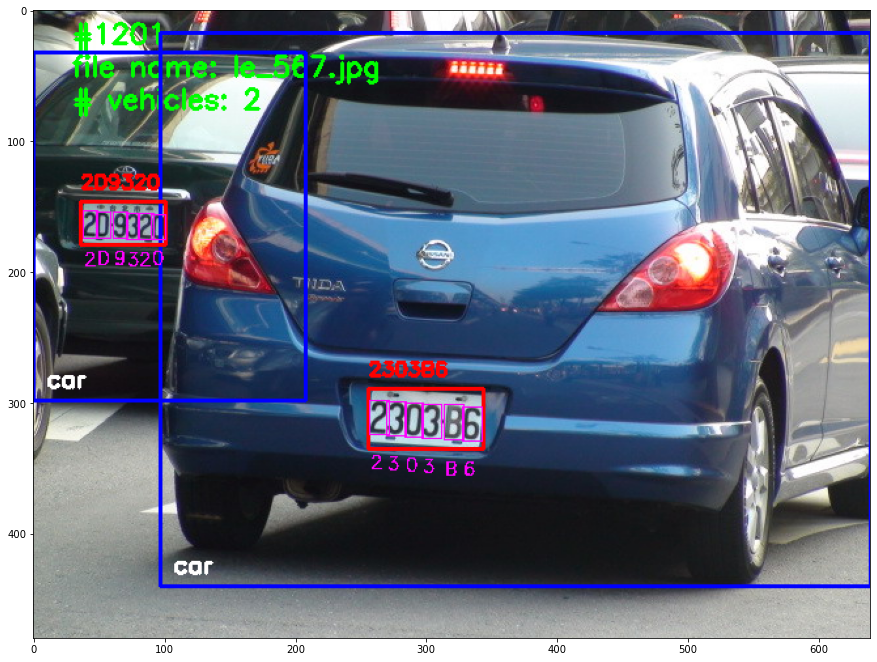

In [71]:
# Plotting images with all the labels to visualise and ensure everything is good.
visualise_dataset(path_to_imgs, all_labels)  # Use the letters "a" and "d" to change sample.